# CNN keywords from first sample (useful to get insights on new words to search)

In [1]:
import os
import requests 
import time
import string
import networkx as nx
import itertools
import networkx as nx
import pandas as pd
import json
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ftrole/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# run this to import from gdrive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NS_project_data')    # write me your email in the group and I'll share with you this folder
CNN_df = pd.read_csv('/content/drive/MyDrive/NS_project_data/data/CNN_all_tweets_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# instead run this to import from the repository 
CNN_df =pd.read_csv('../data/CNN_coronavirus_202001220000_202002220000.csv')

In [3]:
CNN_df

created_at                   id               id_str  \
0    Fri Feb 21 22:30:05 +0000 2020  1230983054883205126  1230983054883205126   
1    Fri Feb 21 19:12:56 +0000 2020  1230933441891442688  1230933441891442688   
2    Fri Feb 21 18:00:09 +0000 2020  1230915124833198080  1230915124833198080   
3    Fri Feb 21 12:53:29 +0000 2020  1230837948326785024  1230837948326785024   
4    Fri Feb 21 12:43:37 +0000 2020  1230835466905276416  1230835466905276416   
..                              ...                  ...                  ...   
832  Wed Jan 22 05:39:05 +0000 2020  1219856992455536640  1219856992455536640   
833  Wed Jan 22 04:01:08 +0000 2020  1219832341801197568  1219832341801197568   
834  Wed Jan 22 03:39:18 +0000 2020  1219826846566699009  1219826846566699009   
835  Wed Jan 22 02:57:56 +0000 2020  1219816437390499840  1219816437390499840   
836  Wed Jan 22 00:22:07 +0000 2020  1219777227052720130  1219777227052720130   

                                                  text  \
0    With the summer wedding season around the corn...   
1    US officials have now confirmed 34 of novel co...   
2    Protesters attacked a convoy of buses carrying...   
3    Protesters attacked a convoy of buses carrying...   
4    RT @NewDay: CNN gained rare access to a field ...   
..                                                 ...   
832  Here's what you should know about the new coro...   
833  A new Chinese coronavirus, a cousin of the SAR...   
834  The United States has its first confirmed case...   
835  Officials in China are racing to contain the o...   
836  The Dow and broader stock market closed in the...   

                                                source  truncated  \
0    <a href="http://www.socialflow.com" rel="nofol...       True   
1    <a href="http://www.socialflow.com" rel="nofol...       True   
2    <a href="http://www.socialflow.com" rel="nofol...       True   
3    <a href="http://www.socialflow.com" rel="nofol...       True   
4    <a href="https://about.twitter.com/products/tw...      False   
..                                                 ...        ...   
832  <a href="http://www.socialflow.com" rel="nofol...       True   
833  <a href="http://www.socialflow.com" rel="nofol...       True   
834  <a href="http://www.socialflow.com" rel="nofol...       True   
835  <a href="http://www.socialflow.com" rel="nofol...       True   
836  <a href="http://www.socialflow.com" rel="nofol...       True   

     in_reply_to_status_id  in_reply_to_status_id_str  in_reply_to_user_id  \
0                      NaN                        NaN                  NaN   
1                      NaN                        NaN                  NaN   
2                      NaN                        NaN                  NaN   
3                      NaN                        NaN                  NaN   
4                      NaN                        NaN                  NaN   
..                     ...                        ...                  ...   
832                    NaN                        NaN                  NaN   
833                    NaN                        NaN                  NaN   
834                    NaN                        NaN                  NaN   
835                    NaN                        NaN                  NaN   
836                    NaN                        NaN                  NaN   

     in_reply_to_user_id_str  ...  \
0                        NaN  ...   
1                        NaN  ...   
2                        NaN  ...   
3                        NaN  ...   
4                        NaN  ...   
..                       ...  ...   
832                      NaN  ...   
833                      NaN  ...   
834                      NaN  ...   
835                      NaN  ...   
836                      NaN  ...   

                                              entities favorited  retweeted  \
0    {'hashtags': [], 'urls': [{'url': 'https://t.c...     False 

In [4]:
def extract_text(df):     # extract the text from the tweets

  list_strings = []

  for index in range(len(df)):

    string = (df.loc[index]['extended_tweet'])

    if type(string) == str :

      s = re.search(':(.+?)https',string).group(1)

      list_strings.append(s)

    else:

      list_strings.append(df.loc[index]['text'])


  return list_strings

In [182]:
def cleaner(tweet,word_list = stopwords.words('english')):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    tweet = tweet.translate(table)# remove punctuation

    special_characters = ['rt','dr','‚Äú','rt','the','to','of','a','an','on','has','have','had','is','was','did','n','et','ha','lt','1','2','5']

    tweet = tweet.split()      
    tweet = ' '.join([ word for word in tweet if word not in word_list and word not in special_characters  ])   #remove useless words
    return tweet



#initialize an empty dict

def frequency_dictionary(df):

  unique_words = {}

  for row in df:

    for word in row.split():
      #if the word is encountered for the first time add to dict as key and set its value to 0
      unique_words.setdefault(word,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
      unique_words[word] += 1

  return unique_words

In [183]:
# this is the code provided by Lejla for cleaning, lemmatising and pos tagging tweets

nltk.download('words')
words = set(nltk.corpus.words.words()) #the last two lines serve to download the corpus of standard English language words
nltk.download('stopwords') #downloading stopwords
stop_words = set(nltk.corpus.stopwords.words("english")) #taking the stop words from English language
nltk.download('wordnet') #downloading wordnet
from nltk.corpus import wordnet as wn #importing it
from nltk.stem.wordnet import WordNetLemmatizer #importing wordnet lemmatizer
from nltk import pos_tag #part-of-speech-tagger
nltk.download('averaged_perceptron_tagger') #downloading tagger
from collections import defaultdict #defaultdict returns default value for non-existant keys you try to  access based on the function you passed in the constructor
tag_map = defaultdict(lambda : wn.NOUN) #here we define that wn.NOUN is the default value for the dict
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemma_pos_cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase
    # francesco: I removed also all 2 letters words and removed from the following line "if w in words" 
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if len(w)>2 and w not in stop_words ) #remove stop words
    lemma_function = WordNetLemmatizer()

    #basically we use pos_tag function on tokens that we get by applying wordpunct tokenization
    #to tweet (it separates all the words and symbols)
    #then we pass the token along with it's wordnet pos value that we get from the tag_map dictionary (noun, adjective, verb or adverb) to the lemma function (the WordNetLemmatizer())

    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize

    tweet = str.lower(tweet) #to lowercase
    return tweet

[nltk_data] Downloading package words to /home/ftrole/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ftrole/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ftrole/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ftrole/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [199]:
df_text = extract_text(CNN_df)
cleaned_df_text = [cleaner(el) for el in df_text]

freq_dict = frequency_dictionary(cleaned_df_text)
freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1],reverse = True))   #order from more frequent to less frequent word

In [200]:
cleaned_df_text[0:10]

['summer wedding season around corner coronavirus outbreak could leave bride panic may unable get wed gown want big day',
 'official confirm novel coronavirus country accord announcement friday center disease control prevention include case among repatriated individual well case',
 'protester attack convoy bus carry ukrainian national evacuate chinese city wuhan injure nine police officer one civilian global fear misconception spread coronavirus outbreak',
 'protester attack convoy bus carry ukrainian national evacuate chinese city wuhan injure nine police officer one civilian global fear misconception spread coronavirus outbreak',
 'cnn gain rare access field hospital wuhan china epicenter coronavirus outbreak reveals dire',
 'eleven american monitor university nebraska medical center coronavirus evacuate cruise ship japan test positive virus hospital say',
 'rampant ignorance misinformation novel coronavirus expert say lead racist xenophobic attack fellow american anyone look asian p

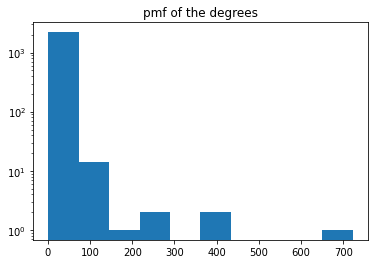

In [201]:
plt.hist(freq_dict.values(),log = True)
plt.title('pmf of the degrees')
plt.show()

In [202]:
print('most frequent words in the CNN pulled csv \n')
print([key for key in freq_dict.keys() if freq_dict[key]>15])   

most frequent words in the CNN pulled csv 

['coronavirus', 'wuhan', 'china', 'outbreak', 'case', 'say', 'people', 'health', 'spread', 'confirm', 'chinese', 'death', 'ship', 'novel', 'state', 'official', 'country', 'world', 'day', 'quarantine', 'cruise', 'virus', 'travel', 'new', 'mainland', 'two', 'accord', 'number', 'flight', 'first', 'test', 'passenger', 'city', 'hong', 'kong', 'continue', '000', 'report', 'total', 'american', 'deadly', 'center', 'patient', 'global', 'least', 'evacuate', 'japan', 'million', 'authority', 'government', 'infect', 'disease', 'close', 'national', 'due', 'take', 'citizen', 'one', 'week', 'hospital', 'toll', 'control', 'airline', 'contain', 'united', 'announce', 'province', 'medical', 'hubei', 'across', 'kill', 'help', 'include', 'concern', 'find', 'fear', 'positive', '100', 'year', 'three', 'public', 'organization', 'die', 'update', 'could', 'princess', 'may', 'prevention', 'infection', 'california', 'doctor', 'statement', 'emergency', 'around', 'diamond'

In [203]:
## Adjacency matrix building
def adj_matrix(freq_dict,cleaned_df_text):   

  words = sorted(list(freq_dict.keys()))

  A = pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words )

  for phrase in cleaned_df_text:

    words_list = [word for word in words if word in phrase]

    couples = [(words_list[i],words_list[j]) for i in range(len(words_list)) for j in range(i+1,len(words_list))]

    for w1,w2 in couples:

          A.loc[w1,w2] += 1

  return np.maximum( A, A.transpose() )


In [204]:
A = adj_matrix(freq_dict,cleaned_df_text)   #version to improve for efficiency

spy plot of the adjacency matrix



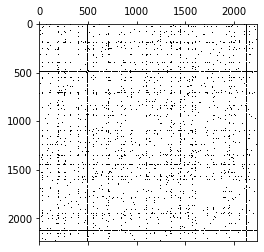

frequency table of bigrams of CNN csv (ordered by alphanumeric order) 

         ."\  .\'  .‚Äù\  000  011  013  016  017  018  100  ...  yet  yokohama  \
."\      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
.\'      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
.‚Äù\      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
000      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0  ...  1.0       0.0   
011      0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
yum      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
zealand  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
zero     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
zhong    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0       0.0   
zone     0.0  0.0  0.0  0.0  0.0 

In [205]:
print('spy plot of the adjacency matrix\n')
plt.spy(A)
plt.show()
print('=====================================\nfrequency table of bigrams of CNN csv (ordered by alphanumeric order) \n')
print(A)

In [206]:
# Constructing the graph object from the adjacency matrix

G = nx.convert_matrix.from_numpy_array(A.to_numpy())
G = nx.relabel_nodes(G , mapping = dict([ (i,sorted(list(freq_dict.keys()))[i]) for i in range(len(freq_dict.keys())) ]) ) 
print('is connected: ',nx.is_connected(G))

is connected:  True


### Pagerank

In [207]:
# Calculating the pagerank on graph G, teleportation probability here is 0.15 but since the graph is strongly connected we can set it to zero if we want
pr = nx.algorithms.pagerank(G,alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse  = True))

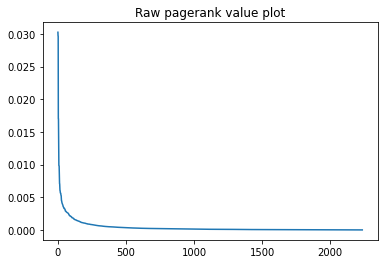

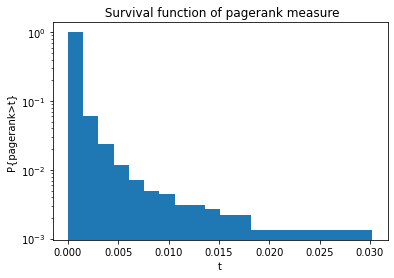

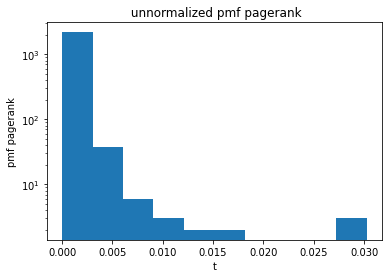

In [208]:
plt.plot(list(pr.values()))
plt.title('Raw pagerank value plot')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{pagerank>t}')
plt.title(' Survival function of pagerank measure')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf pagerank')
plt.title(' unnormalized pmf pagerank')
plt.show()

With this plot we can filtrate out meaningful words by choosing a threshold on the pagerank. As a tentative, we filter out by thresholding at the last step, so we take only words with a pagerank value > 0.020

In [209]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  print(pd.DataFrame(l))

  return 

In [210]:
threshold(pr,0.020)

             0         1
0        virus  0.030243
1       corona  0.029688
2  coronavirus  0.029659


filtering out by using thresholds we can selected new meaningful keywords to use in order to get new data.

In [211]:
threshold(pr,0.003)

              0         1
0         virus  0.030243
1        corona  0.029688
2   coronavirus  0.029659
3          wuha  0.017039
4         wuhan  0.017021
5         china  0.014591
6            la  0.012752
7         break  0.009860
8         outbr  0.009816
9      outbreak  0.009793
10          pre  0.008869
11          day  0.007544
12          say  0.007093
13         case  0.007058
14          men  0.006512
15        healt  0.006060
16       health  0.006033
17           do  0.005774
18       spread  0.005666
19           nu  0.005659
20          eat  0.005627
21       people  0.005569
22          inc  0.005349
23          try  0.005310
24          eve  0.005243
25         port  0.004704
26        state  0.004504
27      confirm  0.004483
28       infect  0.004353
29        count  0.004313
30           go  0.004141
31          man  0.004086
32          new  0.004048
33          art  0.003944
34         land  0.003927
35          rat  0.003879
36      chinese  0.003783
37      coun

There's a pick in pagerank value around 0.02, we extract this words and use this ones as new keywords for a new twitter pull.

Since the graph is undirected hubs and authorities are the same thing.

### Betweenness centrality

In [167]:
bet_centr = nx.betweenness_centrality(G)
bet_centr = dict(sorted(bet_centr.items(), key=lambda item: item[1],reverse  = True))

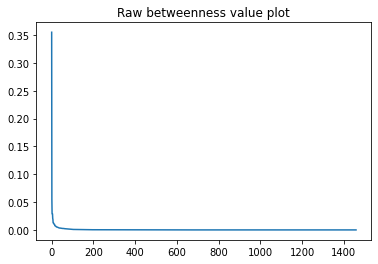

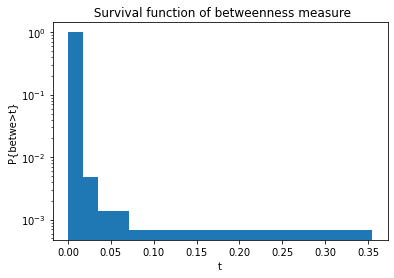

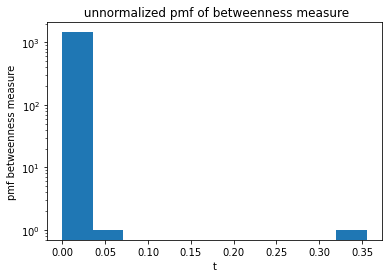

In [50]:
plt.plot(list(bet_centr.values()))
plt.title('Raw betweenness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{betwe>t}')
plt.title(' Survival function of betweenness measure')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf betweenness measure')
plt.title(' unnormalized pmf of betweenness measure')
plt.show()

In [51]:
threshold(bet_centr,0.0018)

           0         1
0             0.355168
1      china  0.055031
2         la  0.029123
3      break  0.028976
4   outbreak  0.028782
..       ...       ...
64     enter  0.002182
65   country  0.002054
66      ship  0.001915
67      form  0.001840
68    number  0.001825

[69 rows x 2 columns]


### closeness centrality

In [52]:
close_centr = nx.closeness_centrality(G)
close_centr = dict(sorted(close_centr.items(), key=lambda item: item[1],reverse  = True))

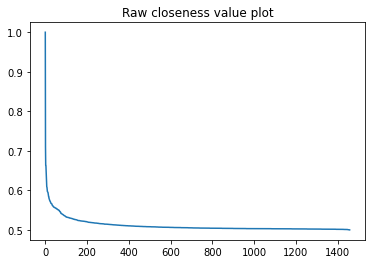

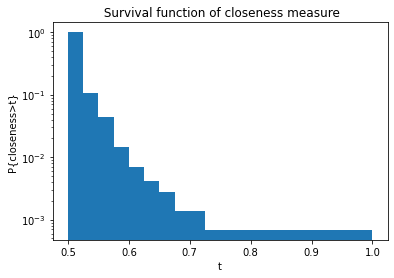

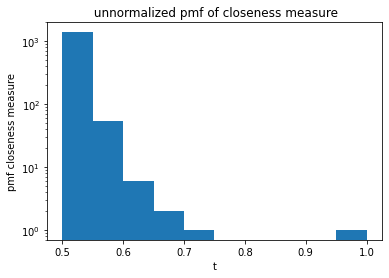

In [54]:
plt.plot(list(close_centr.values()))
plt.title('Raw closeness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of closeness measure')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf closeness measure')
plt.title(' unnormalized pmf of closeness measure')
plt.show()

In [ ]:
threshold(close_centr,0.54)

              0         1
0         covid  0.891005
1            19  0.841159
2       covid19  0.840319
3            de  0.789128
4            us  0.744145
5           day  0.613032
6       vaccine  0.613032
7           man  0.600999
8           ron  0.600571
9            go  0.592124
10          new  0.591708
11          der  0.580890
12         year  0.578495
13          end  0.576712
14          era  0.575726
15          ill  0.574548
16       nation  0.572205
17          eve  0.570654
18    vaccinate  0.569111
19          use  0.568919
20         said  0.567385
21       health  0.567003
22   vaccinated  0.566813
23          one  0.566431
24        virus  0.566431
25          age  0.565670
26     pandemic  0.565101
27        count  0.559654
28          sit  0.557063
29  coronavirus  0.555409
30       people  0.553765
31        child  0.553401
32          say  0.552856
33          get  0.552312
34     children  0.550867
35           eu  0.550147
36        world  0.549429
37     offic

### Katz centrality (it just required too many iterations to reach convergence)

### TF-IDF

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1))   # ngram range can be changed to obtain measures regarding n grams instead of single words

X = tfidf.fit_transform(cleaned_df_text).toarray()    # entry (i,j) if Tfidf measure of word_list[j] in document i

word_list = tfidf.get_feature_names_out()

In [ ]:
tfidf_df = pd.DataFrame(X,columns = word_list)

tfidf_df

10  100  10000  10day   11  ...  youth  yvonne  zients  zones  zoo
0    0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
1    0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
2    0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
3    0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
4    0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
..   ...  ...    ...    ...  ...  ...    ...     ...     ...    ...  ...
225  0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
226  0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
227  0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
228  0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0
229  0.0  0.0    0.0    0.0  0.0  ...    0.0     0.0     0.0    0.0  0.0

[230 rows x 1677 columns]

In [ ]:
tfidf_word_measure = np.mean(tfidf_df,axis = 0)

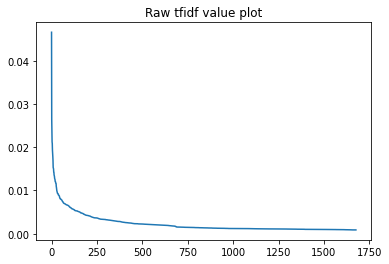

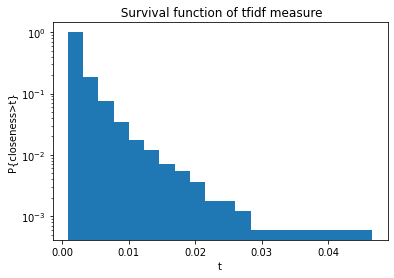

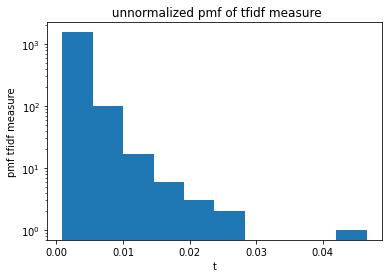

In [ ]:
plt.plot(sorted(list(tfidf_word_measure),reverse = True))
plt.title('Raw tfidf value plot')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of tfidf measure')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf tfidf measure')
plt.title(' unnormalized pmf of tfidf measure')
plt.show()

In [ ]:
threshold(dict([(word,tfidf_df[word].loc[1] ) for word in word_list]) ,0.001)     #pretty stable measure, this are a way more significant than all the others

            0         1
0   according  0.235083
1     anthony  0.280911
2     covid19  0.085191
3     current  0.334169
4      faucin  0.334169
5        know  0.280911
6     omicron  0.225373
7   resistant  0.334169
8      states  0.230025
9         two  0.253593
10     united  0.261354
11   vaccines  0.197498
12    variant  0.200334
13      weeks  0.261354
14    whether  0.246747


# BBC keywords from first sample (useful to get insights on new words to search)

In [ ]:
os.chdir('/content/drive/MyDrive/NS_project_data')    

In [ ]:
BBC_df = pd.read_csv('/content/drive/MyDrive/NS_project_data/data/BBC_all_tweets_df.csv')

In [ ]:
BBC_df

created_at  ...  extended_entities
0    Mon Nov 29 04:20:10 +0000 2021  ...                NaN
1    Sun Nov 28 15:57:17 +0000 2021  ...                NaN
2    Sun Nov 28 15:37:02 +0000 2021  ...                NaN
3    Sun Nov 28 04:32:48 +0000 2021  ...                NaN
4    Sun Nov 28 03:25:14 +0000 2021  ...                NaN
..                              ...  ...                ...
105  Sun Oct 31 17:35:33 +0000 2021  ...                NaN
106  Sat Oct 30 11:59:15 +0000 2021  ...                NaN
107  Sat Oct 30 09:46:05 +0000 2021  ...                NaN
108  Sat Oct 30 09:26:05 +0000 2021  ...                NaN
109  Sat Oct 30 08:55:02 +0000 2021  ...                NaN

[110 rows x 32 columns]

In [ ]:
df_text = extract_text(BBC_df)
cleaned_df_text = [cleaner(el) for el in df_text]

freq_dict = frequency_dictionary(cleaned_df_text)
freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1],reverse = True))   #order from more frequent to less frequent word

In [ ]:
cleaned_df_text[0:10]

['covid dutch police arrest quarantine hotel escapee couple',
 'us troops punished refusing covid jabs',
 'covidpositive czech president appoints new pm inside plexiglass box',
 'covid netherlands enters partial lockdown amid surging infections',
 'covid israel impose travel ban foreigners new variant',
 'covid variants vaccines still work',
 '‚Äúwe‚Äôve fastest vaccine rollout europe fastest booster campaign europe‚Äù prime minister boris johnson‚Ä¶',
 'new omicron covid variant concern world health organization says',
 'teaching union concerned covid rates jersey',
 'two cases new variant covid detected uk']

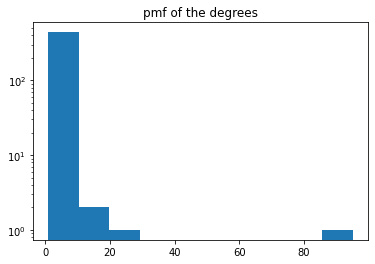

In [ ]:
plt.hist(freq_dict.values(),log = True)
plt.title('pmf of the degrees')
plt.show()

In [ ]:
print('most frequent words in the CNN pulled csv \n')
print([key for key in freq_dict.keys() if freq_dict[key]>15])   

most frequent words in the CNN pulled csv 

['covid', 'new']


In [ ]:
A = adj_matrix(freq_dict,cleaned_df_text)   #version to improve for efficiency

spy plot of the adjacency matrix



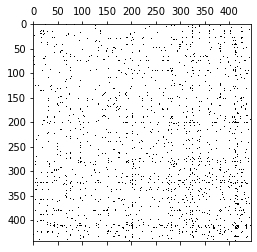

frequency table of bigrams of CNN csv (ordered by alphanumeric order) 

           100000   12   16  500000  ...  zero  zerocovid  ‚Äòwaning  ‚Äúwe‚Äôve
100000        0.0  0.0  0.0     0.0  ...   0.0        0.0      0.0     0.0
12            0.0  0.0  0.0     0.0  ...   0.0        0.0      0.0     0.0
16            0.0  0.0  0.0     0.0  ...   0.0        0.0      0.0     0.0
500000        0.0  0.0  0.0     0.0  ...   0.0        0.0      0.0     0.0
511           0.0  0.0  0.0     0.0  ...   0.0        0.0      0.0     0.0
...           ...  ...  ...     ...  ...   ...        ...      ...     ...
worried       0.0  0.0  0.0     0.0  ...   0.0        0.0      1.0     0.0
zero          0.0  0.0  0.0     0.0  ...   0.0        1.0      0.0     0.0
zerocovid     0.0  0.0  0.0     0.0  ...   1.0        0.0      0.0     0.0
‚Äòwaning       0.0  0.0  0.0     0.0  ...   0.0        0.0      0.0     0.0
‚Äúwe‚Äôve        0.0  0.0  0.0     0.0  ...   0.0        0.0      0.0     0.0

[444 rows x 444

In [ ]:
print('spy plot of the adjacency matrix\n')
plt.spy(A)
plt.show()
print('=====================================\nfrequency table of bigrams of CNN csv (ordered by alphanumeric order) \n')
print(A)

In [ ]:
# Constructing the graph object from the adjacency matrix

G = nx.convert_matrix.from_numpy_array(A.to_numpy())
G = nx.relabel_nodes(G , mapping = dict([ (i,sorted(list(freq_dict.keys()))[i]) for i in range(len(freq_dict.keys())) ]) ) 
print('is connected: ',nx.is_connected(G))

is connected:  True


### Pagerank

In [ ]:
# Calculating the pagerank on graph G, teleportation probability here is 0.15 but since the graph is strongly connected we can set it to zero if we want
pr = nx.algorithms.pagerank(G,alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse  = True))

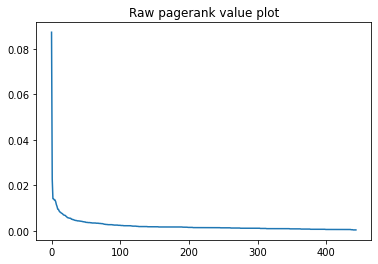

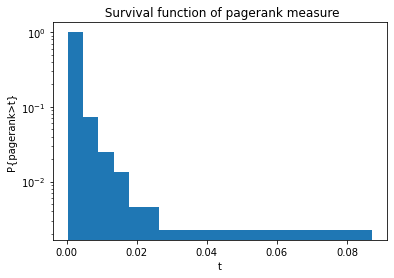

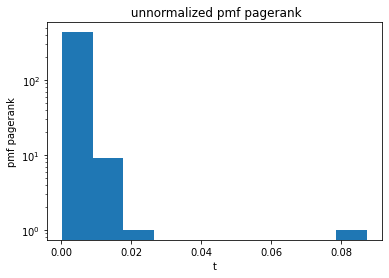

In [ ]:
plt.plot(list(pr.values()))
plt.title('Raw pagerank value plot')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{pagerank>t}')
plt.title(' Survival function of pagerank measure')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf pagerank')
plt.title(' unnormalized pmf pagerank')
plt.show()

With this plot we can filtrate out meaningful words by choosing a threshold on the pagerank. As a tentative, we filter out by thresholding at the last step, so we take only words with a pagerank value > 0.020

In [ ]:
threshold(pr,0.020)

       0         1
0  covid  0.087225
1    new  0.022646


filtering out by using thresholds we can selected new meaningful keywords to use in order to get new data.

In [ ]:
threshold(pr,0.003)

          0         1
0     covid  0.087225
1       new  0.022646
2   vaccine  0.014110
3        us  0.014004
4   variant  0.013537
..      ...       ...
71   impose  0.003217
72    still  0.003144
73   curfew  0.003133
74      two  0.003130
75     risk  0.003041

[76 rows x 2 columns]


There's a pick in pagerank value around 0.02, we extract this words and use this ones as new keywords for a new twitter pull.

Since the graph is undirected hubs and authorities are the same thing.

### Betweenness centrality

In [ ]:
bet_centr = nx.betweenness_centrality(G)
bet_centr = dict(sorted(bet_centr.items(), key=lambda item: item[1],reverse  = True))

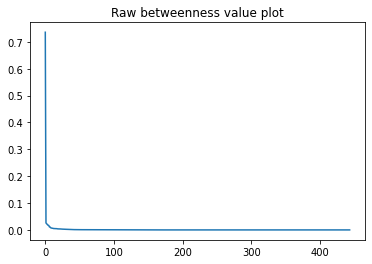

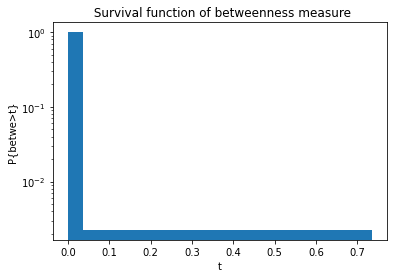

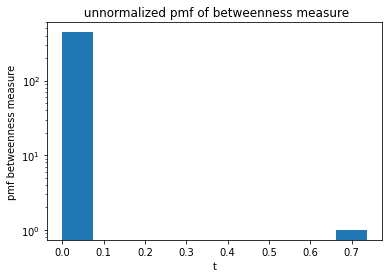

In [ ]:
plt.plot(list(bet_centr.values()))
plt.title('Raw betweenness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{betwe>t}')
plt.title(' Survival function of betweenness measure')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf betweenness measure')
plt.title(' unnormalized pmf of betweenness measure')
plt.show()

In [ ]:
threshold(bet_centr,0.0018)

               0         1
0          covid  0.736007
1            new  0.025935
2        vaccine  0.022788
3             us  0.020037
4         europe  0.017466
5           test  0.016919
6           rica  0.011089
7      infection  0.010818
8          child  0.007759
9       children  0.006864
10      lockdown  0.006291
11      pandemic  0.006072
12         world  0.005202
13        people  0.005110
14            uk  0.004966
15           war  0.004839
16       covid19  0.004608
17       variant  0.004537
18         india  0.003908
19       booster  0.003887
20           say  0.003753
21         johns  0.003605
22          case  0.003531
23          safe  0.003193
24  restrictions  0.003021
25          fast  0.002926
26        school  0.002879
27           get  0.002748
28         south  0.002571
29          full  0.002380
30           on‚Ä¶  0.002325
31         death  0.002191
32        record  0.002164
33        africa  0.001976
34      hospital  0.001869


### closeness centrality

In [ ]:
close_centr = nx.closeness_centrality(G)
close_centr = dict(sorted(close_centr.items(), key=lambda item: item[1],reverse  = True))

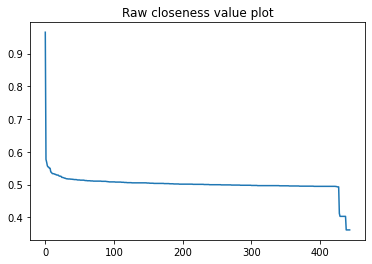

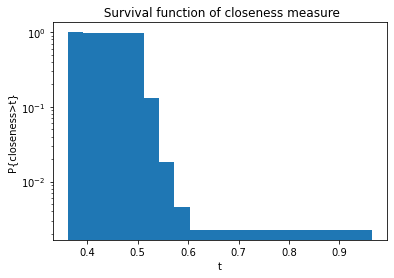

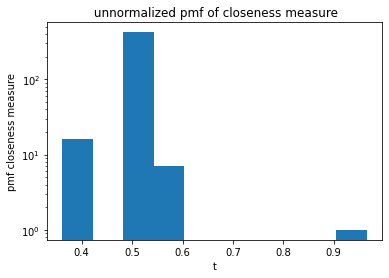

In [ ]:
plt.plot(list(close_centr.values()))
plt.title('Raw closeness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of closeness measure')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf closeness measure')
plt.title(' unnormalized pmf of closeness measure')
plt.show()

In [ ]:
threshold(close_centr,0.54)

           0         1
0      covid  0.965142
1        new  0.576823
2         us  0.567949
3    vaccine  0.557233
4       rica  0.553750
5  infection  0.553059
6     europe  0.549628
7       test  0.549628


### Katz centrality (it just required too many iterations to reach convergence)

### TF-IDF

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1))   # ngram range can be changed to obtain measures regarding n grams instead of single words

X = tfidf.fit_transform(cleaned_df_text).toarray()    # entry (i,j) if Tfidf measure of word_list[j] in document i

word_list = tfidf.get_feature_names_out()

In [ ]:
tfidf_df = pd.DataFrame(X,columns = word_list)

tfidf_df

100000   12   16  500000  ...  worldwide  worried  zero  zerocovid
0       0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
1       0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
2       0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
3       0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
4       0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
..      ...  ...  ...     ...  ...        ...      ...   ...        ...
105     0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
106     0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
107     0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
108     0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0
109     0.0  0.0  0.0     0.0  ...        0.0      0.0   0.0        0.0

[110 rows x 440 columns]

In [ ]:
tfidf_word_measure = np.mean(tfidf_df,axis = 0)

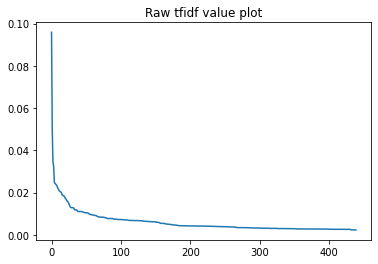

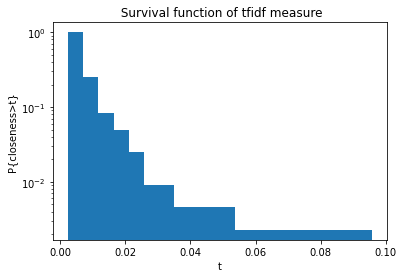

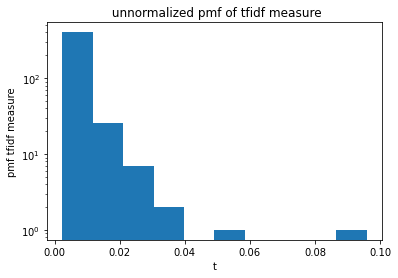

In [ ]:
plt.plot(sorted(list(tfidf_word_measure),reverse = True))
plt.title('Raw tfidf value plot')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of tfidf measure')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf tfidf measure')
plt.title(' unnormalized pmf of tfidf measure')
plt.show()

In [ ]:
threshold(dict([(word,tfidf_df[word].loc[1] ) for word in word_list]) ,0.001)     #pretty stable measure, this are a way more significant than all the others

          0         1
0     covid  0.106211
1      jabs  0.404623
2  punished  0.469496
3  refusing  0.469496
4    troops  0.469496
5        us  0.404623


# Reuters keywords from first sample (useful to get insights on new words to search)

In [ ]:
os.chdir('/content/drive/MyDrive/NS_project_data')    

In [ ]:
R_df = pd.read_csv('/content/drive/MyDrive/NS_project_data/data/Reuters_all_tweets_df.csv')

In [ ]:
R_df

created_at  ...  retweeted_status
0     Mon Nov 29 10:00:27 +0000 2021  ...               NaN
1     Mon Nov 29 09:55:15 +0000 2021  ...               NaN
2     Mon Nov 29 09:20:19 +0000 2021  ...               NaN
3     Mon Nov 29 09:10:18 +0000 2021  ...               NaN
4     Mon Nov 29 08:05:17 +0000 2021  ...               NaN
...                              ...  ...               ...
1139  Sat Oct 30 02:55:00 +0000 2021  ...               NaN
1140  Sat Oct 30 02:20:28 +0000 2021  ...               NaN
1141  Sat Oct 30 00:45:00 +0000 2021  ...               NaN
1142  Sat Oct 30 00:25:23 +0000 2021  ...               NaN
1143  Sat Oct 30 00:15:00 +0000 2021  ...               NaN

[1144 rows x 32 columns]

In [ ]:
df_text = extract_text(R_df)
cleaned_df_text = [cleaner(el) for el in df_text]

freq_dict = frequency_dictionary(cleaned_df_text)
freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1],reverse = True))   #order from more frequent to less frequent word

In [ ]:
cleaned_df_text[0:10]

['skorea shelves plans ease covid measures due high case count omicron',
 'thermo fisher says covid19 tests accurately detects omicron variant',
 'portugal detects 13 cases omicron covid19 variant',
 'omicron threatens oil demand recovery already hit europes rising covid cases',
 'new zealand ease covid measures week despite omicron threat pm',
 'parts northern china tighten curbs new covid19 flareups',
 'first suspected case omicron variant covid19 detected switzerland',
 'dutch police arrest couple attempting flee quarantine spain',
 'thermo fisher says covid19 tests accurately detects omicron variant',
 'beijing‚Äôs bet covidzero worsens odds wynn macau sands china rivals draconian restrictions plus fresh clampdown vips delay recovery worlds largest casino hub says']

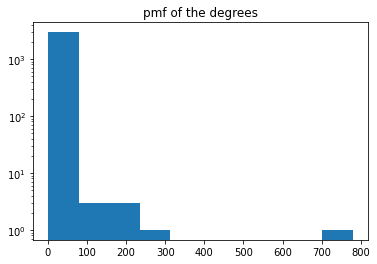

In [ ]:
plt.hist(freq_dict.values(),log = True)
plt.title('pmf of the degrees')
plt.show()

In [ ]:
print('most frequent words in the CNN pulled csv \n')
print([key for key in freq_dict.keys() if freq_dict[key]>15])   

most frequent words in the CNN pulled csv 

['covid19', 'covid', 'new', 'us', 'vaccine', 'cases', 'variant', 'said', 'health', 'says', 'booster', 'vaccines', 'first', 'record', 'pill', 'travel', 'shots', 'lockdown', 'europe', 'restrictions', 'south', 'africa', 'pfizer', 'uk', 'deaths', 'curbs', 'shot', 'dutch', 'children', 'doses', 'measures', 'countries', 'surge', 'infections', 'people', 'biden', 'country', 'minister', 'coronavirus', 'pandemic', 'austria', 'government', 'vaccinated', 'omicron', 'eu', 'daily', 'germany', 'reports', 'adults', 'china', 'mandate', 'cdc', 'president', 'britain', 'amid', 'rules', 'wave', 'global', 'hit', 'use', 'hospitals', 'states', 'drug', 'time', 'back', 'data', 'last', 'vaccination', 'unvaccinated', 'moderna', 'week', 'risk', 'mln', 'france', 'world', 'year', 'rise', 'winter', 'antiviral', 'due', 'rising', 'vaccinations', 'may', 'high', 'african', 'one', 'ahead', 'million', 'public', 'billion', 'administration', 'european', 'pfizers', 'border', 'test', 

In [ ]:
A = adj_matrix(freq_dict,cleaned_df_text)   #version to improve for efficiency

spy plot of the adjacency matrix



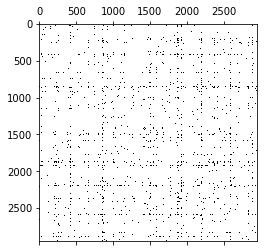

frequency table of bigrams of CNN csv (ordered by alphanumeric order) 

             10   100  10000  100000  105  ...  ‚Äúwe    ‚Ä¶   ‚ö°Ô∏è  ‚ö°Ô∏èaustria    üëá
10          0.0  13.0    4.0     3.0  2.0  ...  0.0  0.0  0.0        0.0  0.0
100        13.0   0.0    4.0     3.0  0.0  ...  0.0  0.0  0.0        0.0  0.0
10000       4.0   4.0    0.0     3.0  0.0  ...  0.0  0.0  0.0        0.0  0.0
100000      3.0   3.0    3.0     0.0  0.0  ...  0.0  0.0  0.0        0.0  0.0
105         2.0   0.0    0.0     0.0  0.0  ...  0.0  0.0  0.0        0.0  0.0
...         ...   ...    ...     ...  ...  ...  ...  ...  ...        ...  ...
‚Äúwe         0.0   0.0    0.0     0.0  0.0  ...  0.0  0.0  1.0        0.0  0.0
‚Ä¶           0.0   0.0    0.0     0.0  0.0  ...  0.0  0.0  0.0        0.0  0.0
‚ö°Ô∏è          0.0   0.0    0.0     0.0  0.0  ...  1.0  0.0  0.0        1.0  0.0
‚ö°Ô∏èaustria   0.0   0.0    0.0     0.0  0.0  ...  0.0  0.0  1.0        0.0  0.0
üëá           0.0   0.0    0.0     0.0  0.

In [ ]:
print('spy plot of the adjacency matrix\n')
plt.spy(A)
plt.show()
print('=====================================\nfrequency table of bigrams of CNN csv (ordered by alphanumeric order) \n')
print(A)

In [ ]:
# Constructing the graph object from the adjacency matrix

G = nx.convert_matrix.from_numpy_array(A.to_numpy())
G = nx.relabel_nodes(G , mapping = dict([ (i,sorted(list(freq_dict.keys()))[i]) for i in range(len(freq_dict.keys())) ]) ) 
print('is connected: ',nx.is_connected(G))

is connected:  True


### Pagerank

In [ ]:
# Calculating the pagerank on graph G, teleportation probability here is 0.15 but since the graph is strongly connected we can set it to zero if we want
pr = nx.algorithms.pagerank(G,alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse  = True))

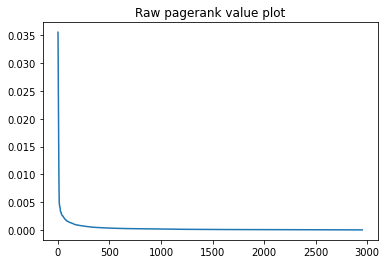

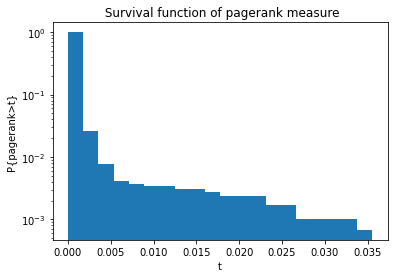

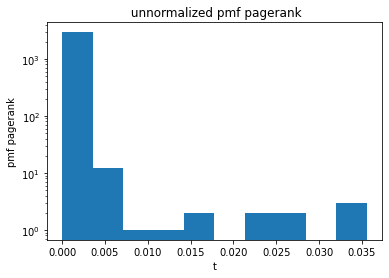

In [ ]:
plt.plot(list(pr.values()))
plt.title('Raw pagerank value plot')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{pagerank>t}')
plt.title(' Survival function of pagerank measure')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf pagerank')
plt.title(' unnormalized pmf pagerank')
plt.show()

With this plot we can filtrate out meaningful words by choosing a threshold on the pagerank. As a tentative, we filter out by thresholding at the last step, so we take only words with a pagerank value > 0.020

In [ ]:
threshold(pr,0.020)

         0         1
0        c  0.035545
1        v  0.035299
2    covid  0.032440
3        9  0.025756
4  covid19  0.025581
5       st  0.023090
6        b  0.021765


filtering out by using thresholds we can selected new meaningful keywords to use in order to get new data.

In [ ]:
threshold(pr,0.003)

          0         1
0         c  0.035545
1         v  0.035299
2     covid  0.032440
3         9  0.025756
4   covid19  0.025581
5        st  0.023090
6         b  0.021765
7        de  0.016963
8        us  0.015110
9        un  0.010934
10  vaccine  0.007474
11      new  0.007090
12     case  0.004871
13      man  0.004790
14      der  0.004711
15      men  0.004636
16  variant  0.004250
17    cases  0.004158
18     said  0.004136
19       ag  0.004114
20    count  0.004105
21   nation  0.003961
22       eu  0.003958
23     shot  0.003506
24     heal  0.003398
25      age  0.003364
26     test  0.003308
27   health  0.003273
28     rica  0.003206
29      day  0.003165
30       go  0.003105
31     rest  0.003075
32      say  0.003067
33     port  0.003066


There's a pick in pagerank value around 0.02, we extract this words and use this ones as new keywords for a new twitter pull.

Since the graph is undirected hubs and authorities are the same thing.

### Betweenness centrality

In [ ]:
bet_centr = nx.betweenness_centrality(G)
bet_centr = dict(sorted(bet_centr.items(), key=lambda item: item[1],reverse  = True))

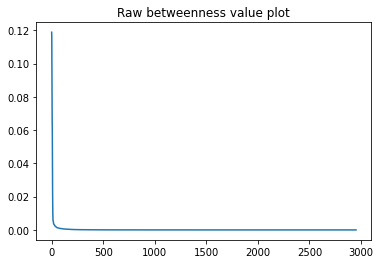

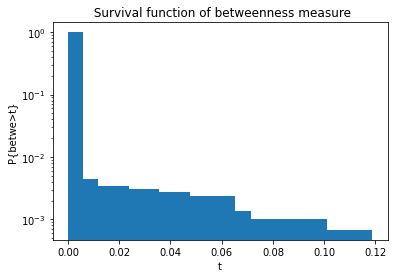

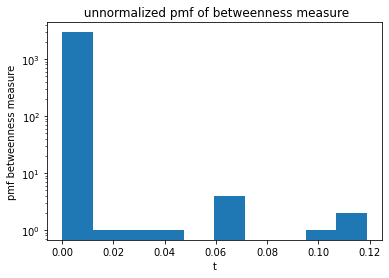

In [ ]:
plt.plot(list(bet_centr.values()))
plt.title('Raw betweenness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{betwe>t}')
plt.title(' Survival function of betweenness measure')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf betweenness measure')
plt.title(' unnormalized pmf of betweenness measure')
plt.show()

In [ ]:
threshold(bet_centr,0.0018)

          0         1
0         c  0.118857
1         v  0.116493
2     covid  0.098962
3        st  0.067677
4         9  0.065018
5   covid19  0.064197
6         b  0.062470
7        de  0.043882
8        us  0.033824
9        un  0.022493
10      new  0.010443
11  vaccine  0.010295
12      men  0.006726
13       ag  0.005628
14     said  0.005510
15      der  0.005459
16      man  0.005246
17    count  0.004100
18     case  0.004093
19   nation  0.003718
20      age  0.003539
21       go  0.003447
22  variant  0.003332
23      day  0.003236
24       eu  0.003222
25      end  0.003149
26     heal  0.002988
27      say  0.002977
28     test  0.002775
29   health  0.002748
30     port  0.002539
31      art  0.002481
32    cases  0.002462
33     shot  0.002185
34     rest  0.002173
35      try  0.002153
36    first  0.002099
37     year  0.002059
38     rica  0.002057
39      low  0.001940
40   strict  0.001931
41      ten  0.001866
42   travel  0.001821


### closeness centrality

In [ ]:
close_centr = nx.closeness_centrality(G)
close_centr = dict(sorted(close_centr.items(), key=lambda item: item[1],reverse  = True))

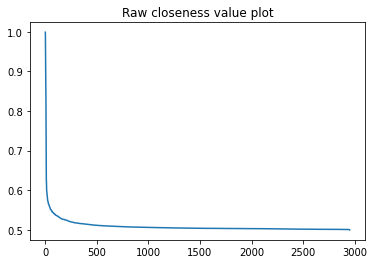

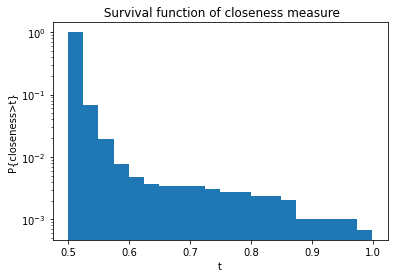

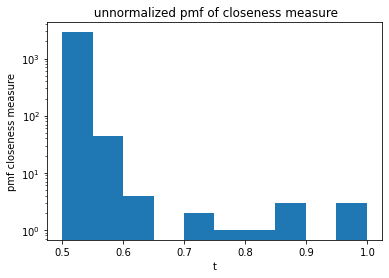

In [ ]:
plt.plot(list(close_centr.values()))
plt.title('Raw closeness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of closeness measure')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf closeness measure')
plt.title(' unnormalized pmf of closeness measure')
plt.show()

In [ ]:
threshold(close_centr,0.54)

          0         1
0         c  0.998647
1         v  0.994274
2     covid  0.950419
3         9  0.867215
4   covid19  0.864169
..      ...       ...
85     rate  0.541254
86  booster  0.540362
87    break  0.540362
88       ‚Äôs  0.540362
89     rule  0.540066

[90 rows x 2 columns]


### Katz centrality (it just required too many iterations to reach convergence)

### TF-IDF

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1))   # ngram range can be changed to obtain measures regarding n grams instead of single words

X = tfidf.fit_transform(cleaned_df_text).toarray()    # entry (i,j) if Tfidf measure of word_list[j] in document i

word_list = tfidf.get_feature_names_out()

In [ ]:
tfidf_df = pd.DataFrame(X,columns = word_list)

tfidf_df

10  100  10000  100000  ...  zerocovid  zerotolerance  zimbabwe  zone
0     0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
1     0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
2     0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
3     0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
4     0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
...   ...  ...    ...     ...  ...        ...            ...       ...   ...
1139  0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
1140  0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
1141  0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
1142  0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0
1143  0.0  0.0    0.0     0.0  ...        0.0            0.0       0.0   0.0

[1144 rows x 2899 columns]

In [ ]:
tfidf_word_measure = np.mean(tfidf_df,axis = 0)

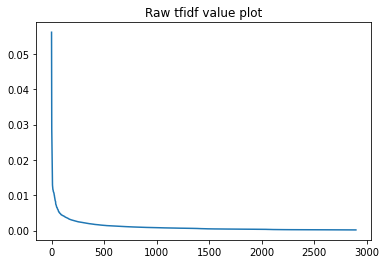

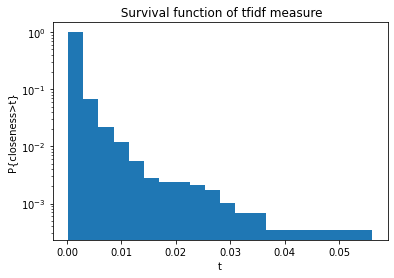

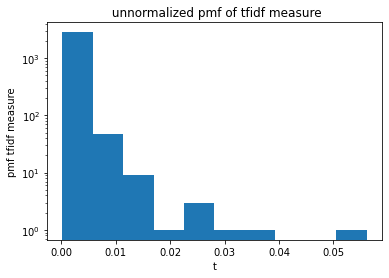

In [ ]:
plt.plot(sorted(list(tfidf_word_measure),reverse = True))
plt.title('Raw tfidf value plot')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of tfidf measure')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf tfidf measure')
plt.title(' unnormalized pmf of tfidf measure')
plt.show()

In [ ]:
threshold(dict([(word,tfidf_df[word].loc[1] ) for word in word_list]) ,0.001)     #pretty stable measure, this are a way more significant than all the others

            0         1
0  accurately  0.432687
1     covid19  0.086303
2     detects  0.379895
3      fisher  0.432687
4     omicron  0.281424
5        says  0.232132
6       tests  0.336708
7      thermo  0.432687
8     variant  0.200304


# AP keywords from first sample (useful to get insights on new words to search)

In [ ]:
os.chdir('/content/drive/MyDrive/NS_project_data')    

In [ ]:
AP_df = pd.read_csv('/content/drive/MyDrive/NS_project_data/data/AP_all_tweets_df.csv')

In [ ]:
AP_df

created_at  ...  display_text_range
0    Sun Nov 28 21:17:05 +0000 2021  ...                 NaN
1    Sun Nov 28 16:02:40 +0000 2021  ...                 NaN
2    Sun Nov 28 00:10:06 +0000 2021  ...                 NaN
3    Sat Nov 27 20:49:08 +0000 2021  ...                 NaN
4    Sat Nov 27 19:06:44 +0000 2021  ...                 NaN
..                              ...  ...                 ...
182  Sat Oct 30 14:26:29 +0000 2021  ...                 NaN
183  Sat Oct 30 14:14:45 +0000 2021  ...                 NaN
184  Sat Oct 30 12:54:04 +0000 2021  ...                 NaN
185  Sat Oct 30 12:40:26 +0000 2021  ...                 NaN
186  Sat Oct 30 09:31:04 +0000 2021  ...                 NaN

[187 rows x 31 columns]

In [ ]:
df_text = extract_text(AP_df)
cleaned_df_text = [cleaner(el) for el in df_text]

freq_dict = frequency_dictionary(cleaned_df_text)
freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1],reverse = True))   #order from more frequent to less frequent word

In [ ]:
cleaned_df_text[0:10]

['covid19 constantly exploits divisions world health organization urged countries impose flight bans southern african nations due concerns new omicron variant many nations already done plan',
 'swiss voters appear set approve legislation introduce special covid19 certificate lets people vaccinated recovered tested negative attend public events gatheringsn',
 'cases coronavirus new omicron variant first identified southern africa reported countries britain hong kong anthony fauci says hasnt detected us yet may already well',
 'breaking italy germany confirmed cases omicron covid19 variant according news reports',
 'politics inflation workers scarce president joe biden‚Äôs poll numbers freefall white house sees common‚Ä¶',
 'europe germanys health minister says hopes sight air force planes transferring patients across country act a‚Ä¶',
 'scientists south africa scrambling combat new covid19 variant omicrons lightning spread across country country‚Äôs case numbers still relatively low om

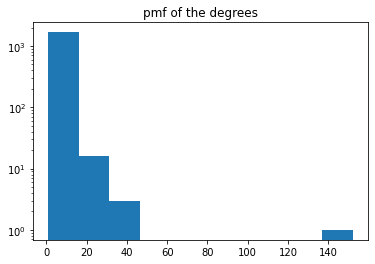

In [ ]:
plt.hist(freq_dict.values(),log = True)
plt.title('pmf of the degrees')
plt.show()

In [ ]:
print('most frequent words in the CNN pulled csv \n')
print([key for key in freq_dict.keys() if freq_dict[key]>15])   

most frequent words in the CNN pulled csv 

['covid19', 'vaccine', 'new', 'europe', 'us', 'virus', 'shots', 'health', 'vaccinated', 'cases', 'coronavirus', 'travel', 'people', 'breaking', 'pandemic', 'kids', 'variant', 'covid', 'could', 'infections', 'vaccines', 'deaths']


In [ ]:
A = adj_matrix(freq_dict,cleaned_df_text)   #version to improve for efficiency

spy plot of the adjacency matrix



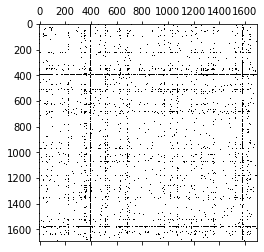

frequency table of bigrams of CNN csv (ordered by alphanumeric order) 

            10  100  100000   11  ...  ‚Äúremove‚Äù  ‚Äúthe  ‚Äútoday  ‚Äúvery
10         0.0  9.0     3.0  2.0  ...       0.0   0.0     0.0    0.0
100        9.0  0.0     3.0  1.0  ...       0.0   0.0     0.0    0.0
100000     3.0  3.0     0.0  0.0  ...       0.0   0.0     0.0    0.0
11         2.0  1.0     0.0  0.0  ...       0.0   0.0     0.0    0.0
1178       0.0  0.0     0.0  1.0  ...       0.0   0.0     0.0    0.0
...        ...  ...     ...  ...  ...       ...   ...     ...    ...
‚Äúomicron‚Äù  0.0  0.0     0.0  0.0  ...       0.0   0.0     0.0    0.0
‚Äúremove‚Äù   0.0  0.0     0.0  0.0  ...       0.0   0.0     0.0    0.0
‚Äúthe       0.0  0.0     0.0  0.0  ...       0.0   0.0     0.0    0.0
‚Äútoday     0.0  0.0     0.0  0.0  ...       0.0   0.0     0.0    0.0
‚Äúvery      0.0  0.0     0.0  0.0  ...       0.0   0.0     0.0    0.0

[1694 rows x 1694 columns]


In [ ]:
print('spy plot of the adjacency matrix\n')
plt.spy(A)
plt.show()
print('=====================================\nfrequency table of bigrams of CNN csv (ordered by alphanumeric order) \n')
print(A)

In [ ]:
# Constructing the graph object from the adjacency matrix

G = nx.convert_matrix.from_numpy_array(A.to_numpy())
G = nx.relabel_nodes(G , mapping = dict([ (i,sorted(list(freq_dict.keys()))[i]) for i in range(len(freq_dict.keys())) ]) ) 
print('is connected: ',nx.is_connected(G))

is connected:  True


### Pagerank

In [ ]:
# Calculating the pagerank on graph G, teleportation probability here is 0.15 but since the graph is strongly connected we can set it to zero if we want
pr = nx.algorithms.pagerank(G,alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse  = True))

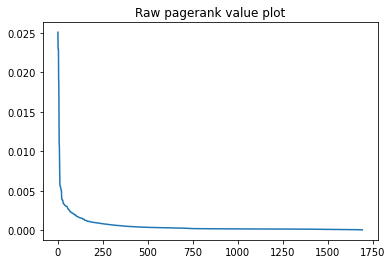

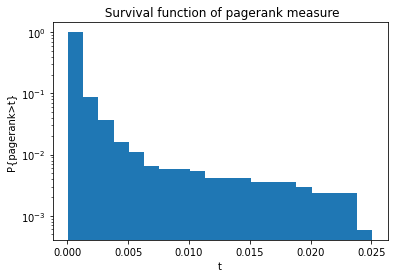

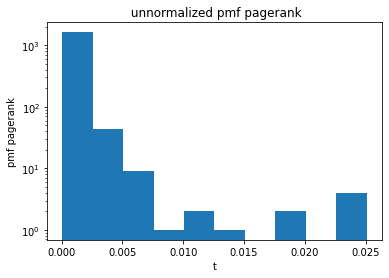

In [ ]:
plt.plot(list(pr.values()))
plt.title('Raw pagerank value plot')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{pagerank>t}')
plt.title(' Survival function of pagerank measure')
plt.show()

print('\n=================================================')

plt.hist(list(pr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf pagerank')
plt.title(' unnormalized pmf pagerank')
plt.show()

With this plot we can filtrate out meaningful words by choosing a threshold on the pagerank. As a tentative, we filter out by thresholding at the last step, so we take only words with a pagerank value > 0.020

In [ ]:
threshold(pr,0.020)

         0         1
0    covid  0.025081
1        9  0.023115
2       19  0.022935
3  covid19  0.022935


filtering out by using thresholds we can selected new meaningful keywords to use in order to get new data.

In [ ]:
threshold(pr,0.003)

              0         1
0         covid  0.025081
1             9  0.023115
2            19  0.022935
3       covid19  0.022935
4            al  0.019171
5            de  0.018537
6            us  0.014131
7            un  0.010923
8            la  0.010724
9       vaccine  0.008824
10        virus  0.006602
11           go  0.005707
12           nn  0.005683
13          new  0.005583
14          eat  0.005549
15       europe  0.005424
16          hot  0.005300
17          day  0.005271
18          age  0.005068
19       nation  0.005048
20         shot  0.004824
21         case  0.003994
22        shots  0.003979
23        death  0.003889
24          end  0.003837
25       health  0.003836
26          say  0.003813
27        break  0.003807
28   vaccinated  0.003651
29        cases  0.003468
30          per  0.003444
31          one  0.003414
32          inc  0.003371
33         test  0.003342
34          ten  0.003295
35          try  0.003273
36          get  0.003257
37     pande

There's a pick in pagerank value around 0.02, we extract this words and use this ones as new keywords for a new twitter pull.

Since the graph is undirected hubs and authorities are the same thing.

### Betweenness centrality

In [ ]:
bet_centr = nx.betweenness_centrality(G)
bet_centr = dict(sorted(bet_centr.items(), key=lambda item: item[1],reverse  = True))

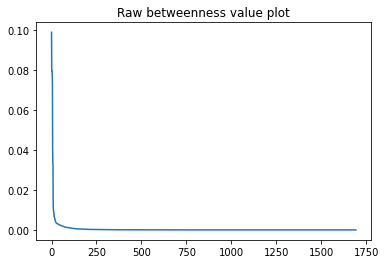

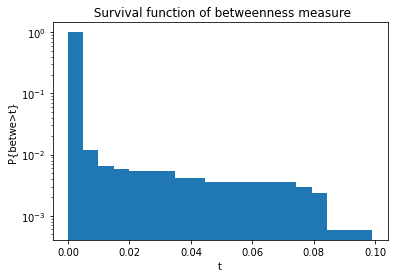

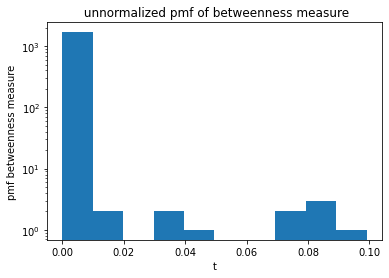

In [ ]:
plt.plot(list(bet_centr.values()))
plt.title('Raw betweenness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{betwe>t}')
plt.title(' Survival function of betweenness measure')
plt.show()

print('\n=================================================')

plt.hist(list(bet_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf betweenness measure')
plt.title(' unnormalized pmf of betweenness measure')
plt.show()

In [ ]:
threshold(bet_centr,0.0018)

              0         1
0         covid  0.099079
1             9  0.080636
2            19  0.079700
3       covid19  0.079700
4            de  0.077438
..          ...       ...
61  coronavirus  0.001946
62     breaking  0.001898
63   government  0.001887
64     restrict  0.001849
65       travel  0.001802

[66 rows x 2 columns]


### closeness centrality

In [ ]:
close_centr = nx.closeness_centrality(G)
close_centr = dict(sorted(close_centr.items(), key=lambda item: item[1],reverse  = True))

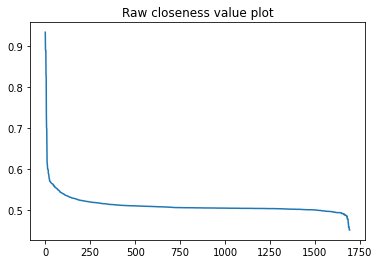

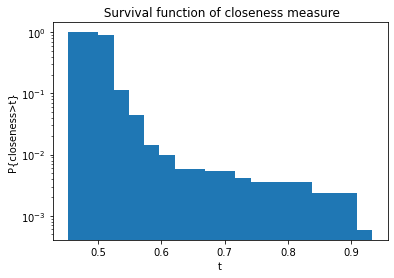

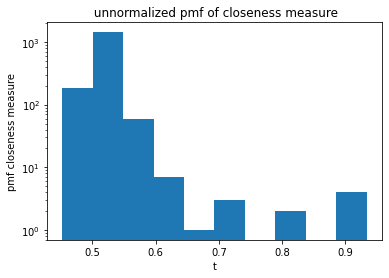

In [ ]:
plt.plot(list(close_centr.values()))
plt.title('Raw closeness value plot')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of closeness measure')
plt.show()

print('\n=================================================')

plt.hist(list(close_centr.values()),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf closeness measure')
plt.title(' unnormalized pmf of closeness measure')
plt.show()

In [ ]:
threshold(close_centr,0.54)

           0         1
0      covid  0.933811
1          9  0.891522
2         19  0.889181
3    covid19  0.889181
4         de  0.829495
..       ...       ...
97       sen  0.540895
98     biden  0.540549
99      east  0.540377
100      son  0.540377
101    surge  0.540377

[102 rows x 2 columns]


### Katz centrality (it just required too many iterations to reach convergence)

### TF-IDF

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1))   # ngram range can be changed to obtain measures regarding n grams instead of single words

X = tfidf.fit_transform(cleaned_df_text).toarray()    # entry (i,j) if Tfidf measure of word_list[j] in document i

word_list = tfidf.get_feature_names_out()

In [ ]:
tfidf_df = pd.DataFrame(X,columns = word_list)

tfidf_df

10  100  100000   11  1178  ...  youre  zeigleramon  zeman  zerotolerance  zoo
0    0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
1    0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
2    0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
3    0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
4    0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
..   ...  ...     ...  ...   ...  ...    ...          ...    ...            ...  ...
182  0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
183  0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
184  0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
185  0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0
186  0.0  0.0     0.0  0.0   0.0  ...    0.0          0.0    0.0            0.0  0.0

[187 rows x 1642 columns]

In [ ]:
tfidf_word_measure = np.mean(tfidf_df,axis = 0)

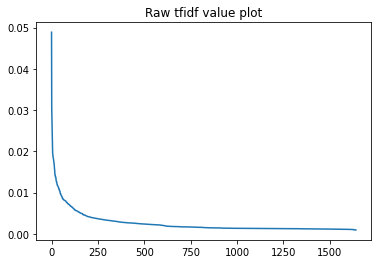

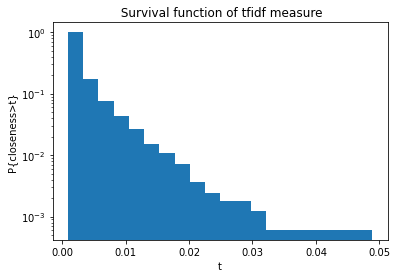

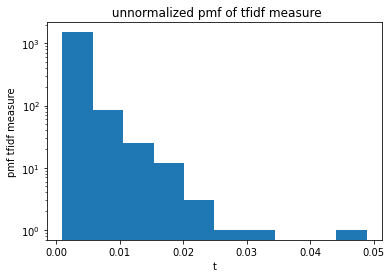

In [ ]:
plt.plot(sorted(list(tfidf_word_measure),reverse = True))
plt.title('Raw tfidf value plot')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True,cumulative=-1 ,bins = 20,density  = True)
plt.xlabel('t')
plt.ylabel('P{closeness>t}')
plt.title(' Survival function of tfidf measure')
plt.show()

print('\n=================================================')

plt.hist(list(tfidf_word_measure),log = True ,cumulative = 0 )
plt.xlabel('t')
plt.ylabel('pmf tfidf measure')
plt.title(' unnormalized pmf of tfidf measure')
plt.show()

In [ ]:
threshold(dict([(word,tfidf_df[word].loc[1] ) for word in word_list]) ,0.001)     #pretty stable measure, this are a way more significant than all the others

              0         1
0        appear  0.254294
1       approve  0.254294
2        attend  0.235694
3   certificate  0.254294
4       covid19  0.056849
5        events  0.235694
6   gatheringsn  0.254294
7     introduce  0.254294
8   legislation  0.254294
9          lets  0.254294
10     negative  0.235694
11       people  0.146427
12       public  0.212260
13    recovered  0.212260
14          set  0.190699
15      special  0.212260
16        swiss  0.254294
17       tested  0.185296
18   vaccinated  0.144293
19       voters  0.254294
